In [1]:
import torch

In [1]:
# src/evaluate.py
import argparse, yaml, torch, os
from torch.utils.data import DataLoader, Dataset
from src.model import SAMDecoderOnlyModel
from src.metrics import iou_score, dice_coeff, precision_recall
from src.transforms import get_image_transforms, mask_transform
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from tqdm import tqdm

In [4]:
with open("config.yaml") as f:
    cfg = yaml.safe_load(f)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt_path = "/mnt/g/Authenta/research/authenta-inpainting-detection/SegForge/checkpoints/finetuned/epoch_6.pth"
model = SAMDecoderOnlyModel(cfg['model']['sam_model_type'], cfg['model']['sam_checkpoint'], 
                            freeze_sam=False, decoder_channels=cfg['model']['decoder_channels'])
model.load_state_dict(torch.load(ckpt_path, map_location='cpu')['model_state'])
model.to(device).eval()


SAMDecoderOnlyModel(
  (sam): Sam(
    (image_encoder): ImageEncoderViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (lin1): Linear(in_features=768, out_features=3072, bias=True)
            (lin2): Linear(in_features=3072, out_features=768, bias=True)
            (act): GELU(approximate='none')
          )
        )
      )
      (neck): Sequential(
        (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): LayerNorm2d()
        (2): Conv2d(256, 256, kernel_size=(3, 3)

In [47]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# Load image using PIL
image_path = "image.jpg"  # Replace with your actual image path
pil_image = Image.open(image_path).convert("RGB")  # Ensure it's RGB

# Define transform pipeline
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),         # Resize to 1024x1024
    transforms.ToTensor()                    # Convert to tensor (C×H×W, values in [0,1])
])

# Apply transform
tensor_image = transform(pil_image)  # Shape: [3, 1024, 1024]

# Optional: Add batch dimension if needed
tensor_image = tensor_image.unsqueeze(0)  # Shape: [1, 3, 1024, 1024]

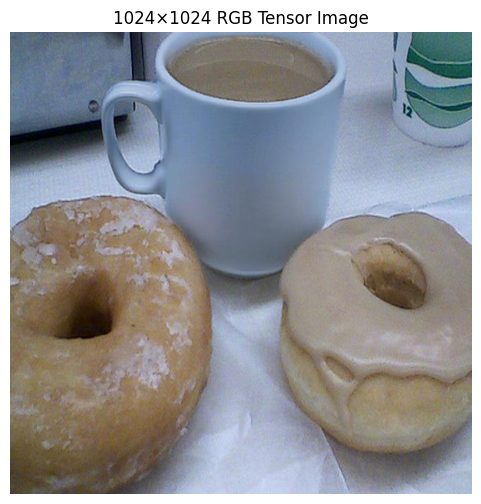

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(tensor_image[0].permute(1, 2, 0))  # Convert to H×W×C for plotting
plt.title("1024×1024 RGB Tensor Image")
plt.axis("off")
plt.show()


In [49]:
with torch.no_grad():
    model.eval()
    feats = model.sam.image_encoder(tensor_image.cuda())
    logits = model.forward_from_embeddings(feats[-1] if isinstance(feats, (list, tuple)) else feats)
    pred_mask = torch.sigmoid(logits).cpu()
    pred_mask = pred_mask.squeeze()

In [50]:
torch.max(pred_mask)

tensor(0.5846)

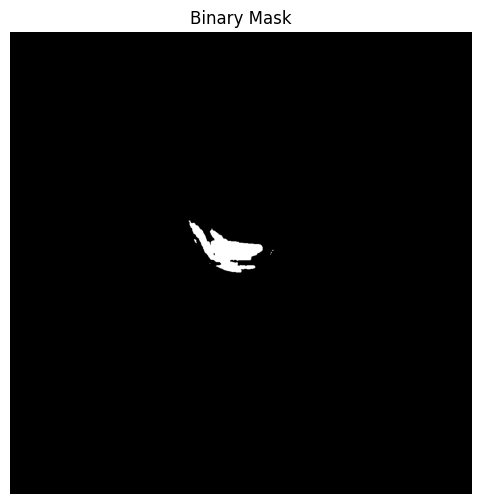

In [57]:

binary_mask = ( pred_mask > 0.5).float()  # Shape: [1, 1024, 1024]

# Plot binary mask
plt.figure(figsize=(6, 6))
plt.imshow(binary_mask, cmap="gray")  # Remove channel dimension
plt.title("Binary Mask")
plt.axis("off")
plt.show()
